# Machine Learning at Berkeley: Machine Learning Decal
## Homework Three: Unsupervised Learning and Autoencoders

Release Date: February 27th, 2019
Due Date: March 11th, 2019
Contributing Authors: Brandon Trabucco

The goal of this homework is to familiarize you with various unsupervised learning and dimensionality reduction algorithms that are commonly used when handling large datasets. In particular, you will implement:

* Extracting The Dataset
* Principal Component Analysis
* A Linear Autoencoder
* A Convolutional Autoencoder
* (Optional) A Variational Autoencoder (VAE for short)

In addition to implementing these algorithms, you will use these algorithms to interpolate between existing data points, and extrapolate to new data points. Since images have nice visualizations, this homework shall use a miniature version of the CelebA (S. Yang et al. 2015) dataset that contains 5000 cropped images of celebrity faces. Feel free to download the full dataset after finishing the homework and tinkering with your models.

S. Yang, P. Luo, C. C. Loy, and X. Tang, "From Facial Parts Responses to Face Detection: A Deep Learning Approach", in IEEE International Conference on Computer Vision (ICCV), 2015

In [2]:
%%capture
# IMPORTANT: you must have all of these repositories properly installed on your machine to complete tis homework.
# you must also have ffmpeg installed. You may find the binaries at https://www.ffmpeg.org/download.html
# Make sure you add the directories that contain the ffmpeg binaries to your path, reinstall matplotlib afterwards
import torch
import torchvision
import torch.nn.functional as F
import glob
import os
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
if not "ffmpeg" in matplotlib.animation.writers.list():
    print("WARNING!!! You must add FFMPEG to your path before you can use the animations in this homework.")
from IPython.display import HTML, display

## Section One: Extracting The Dataset

In this section, you will extract the folder of images into a matrix $X \in \mathcal{R}^{N \times D}$ where the number of rows $N$ corresponds to the number of images in the dataset (5000 in total), and the number of features $D$ corresponds to the RGB values of every pixel in every image (32 * 32 * 3 = 3072 in this case).

In [3]:
def extract_dataset(path_to_images, output_height, output_width, path_to_matrix):
    """Loads each image into memory, processes each image, and saves a matrix to the disk.
    Args:
        path_to_images: string, the path to the directory containing image files.
        output_height: integer, the height to scale each image to.
        output_width: integer, the width to scale each image to.
        path_to_matrix: string, the path where the matrix will be saved.
    """
    all_matching_files = glob.glob(os.path.join(path_to_images, "*.jpg"))
    X = np.zeros([len(all_matching_files), output_height * output_width * 3])
    for i, file in enumerate(all_matching_files):
        # TODO: fill in this section to accomplish the following.
        # 1) load the image with Image.open specified by its file path from the disk
        # 2) resize that image to be a [output_width, output_height] numpy array
        # 3) perform a row-major flatten of the array
        # 3) scale the elements of the array to be in the range [-1, 1]
        # 4) assign the arrya to the ith column of data matrix X
        # BEGIN YOUR CODE
        image = Image.open(file)
        image = image.resize((output_width, output_height))
        image.load()
        image = np.asarray(image, dtype=np.float32).reshape([output_height * output_width * 3])        
        #image = image.flatten()
        image = (image - 127) / 127
        X[i] = image
        # END YOUR CODE
    np.save(os.path.join(path_to_matrix, "dataset.npy"), X)

In [4]:
def load_dataset(path_to_matrix):
    """Loads a matrix containing processed images into the memory.
    Args:
        path_to_matrix: string, the path where the matrix was saved.
    Returns:
        a numpy matrix with 5000 rows (one per image) and 3072 columns.
    """
    return np.load(os.path.join(path_to_matrix, "dataset.npy"))

In [5]:
def show_image(flat_image_vector, output_height, output_width):
    """Displays an image on jupyter notebook using matplotlib imshow.
    Args:
        flat_image_vector: a np.float32 vector with D = 3072 elements.
        output_height: integer, the height to reshape the image to.
        output_width: integer, the width to reshape the image to.
    """
    # TODO: fill in this section to accomplish the following.
    # 1) perform a row-major reshape from a flattened array to a [output_height, output_width, 3] tensor
    # 2) scale the elements of the array to be in the range [0, 1]
    # 3) render the image using matplotlib imshow(...)
    # 4) show() and close() the plot
    # BEGIN YOUR CODE
    image_tensor = np.reshape(flat_image_vector, (output_height, output_width, 3))
    image_tensor = np.interp(image_tensor, (image_tensor.min(), image_tensor.max()), (0,1))
    #image_tensor += 1
    #image_tensor /= 2
    plt.imshow(image_tensor)
    plt.show()
    plt.close()
    # END YOUR CODE

In [6]:
# TODO: fill in this section to accomplish the following.
# 1) call the extract_dataset function with the appropriate paths
# 2) assign the height 32 and the width 32
# BEGIN YOUR CODE
extract_dataset("../../../celeba/", 32, 32, "../../../")
# END YOUR CODE

In [7]:
X = None
# TODO: fill in this section to accomplish the following.
# 1) call the load_dataset function with the appropriate path
# 2) assign the result to a data matrix named X
# BEGIN YOUR CODE
X = load_dataset("../../../")
# END YOUR CODE
print("A matrix with {0} images and {1} features per image was loaded.".format(*X.shape))

A matrix with 5000 images and 3072 features per image was loaded.


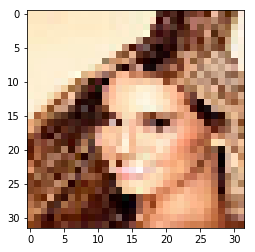

In [8]:
# TODO: fill in this section to accomplish the following.
# 1) call the show_image function using a single row from the matrix X
# BEGIN YOUR CODE
show_image(X[0, :], 32, 32)
# END YOUR CODE

## Section Two: Principal Component Analysis

In this section, you will learn about Principal Component Analysis from an optimization perspective. You will then implement PCA to learn the $K$ principal components from the data matrix $X$. You will then use these principal components to interpolate between random rows of X. Finally, you will sample points in a lower dimensional subspace and invert PCA to generate new images of faces.

The rows of $X$ lives in the space of $\mathcal{R}^{D}$. We define $D$ to be 3072 for the remainder of this homework. The principal components of $X$ provide a sequence of the best linear approximations to X in a lower dimensional subspace $\mathcal{R}^{Q}$ where the rank of the subspace $Q \leq D$ is no larger than the rank of the space that contains $X$. Consider a function of a vector $\lambda$ in $\mathcal{R}^{Q}$.

$$ f(\lambda) = \mu + V_{Q} \lambda $$

This function defines a linear transformation from the space of $\mathcal{R}^{Q}$ to the space of $\mathcal{R}^{D}$. There are two important paraneters in this formulation: namely $\mu$ and $V_{Q}$. The vector $\mu$ is a position in the space of $\mathcal{R}^{D}$. The matrix $V_{Q} \in \mathcal{R}^{D \times Q}$ is a unitary matrix that maps the vector $\lambda$ from the subspace $\mathcal{R}^{Q}$ to the space of the data $\mathcal{R}^{D}$. The goal of PCA is to minimize the following reconstruction error.

$$ \min_{\mu, V_{Q}, \{ \lambda_{i}\} } \sum_{i = 1}^{N} || x_{i} - \mu - V_{Q} \lambda_{i} ||_{2}^{2} $$

Where the vector $x_{i}$ is the row in position i from the data matrix $X$, and the vector $\lambda_{i}$ represent the best approximation of the vector $x_{i}$ in the column space of the matrix $V_{Q}$. The other parameters have been previously defined, and are the same. We take this objective, and we optimize for $\mu$ and $\{ \lambda_{i}\}$.

$$ \mu = \frac{1}{N} \sum_{i = 1}^{N} x_{i} $$
$$ \lambda_{i} = V_{Q}^{T} ( x_{i} - \mu ) $$

The optimization objective now ammounts to solving for the optimal orthonormal matrix $V_{Q}$ that minimizes reconstruction error.

$$ \min_{V_{Q}} \sum_{i = 1}^{N} || x_{i} - \frac{1}{N} \sum_{i = 1}^{N} x_{i} - V_{Q} V_{Q}^{T} ( x_{i} - \frac{1}{N} \sum_{i = 1}^{N} x_{i} ) ||_{2}^{2} $$

The matrix resulting from $V_{Q} V_{Q}^{T}$ can be imagined a projection that maps each data point $x_{i}$ onto the best rank $Q$ approximation. See that we are subtracting the mean from each data point. If we assume each data point already has zero mean, the objective simplifies.

$$ \frac{1}{N} \sum_{i = 1}^{N} x_{i} = 0 \implies \min_{V_{Q}} \sum_{i = 1}^{N} || x_{i} - V_{Q} V_{Q}^{T} x_{i} ||_{2}^{2} $$

The solution may be obtained using Singular Value Decomposition. In particular, we can express the data matrix by its SVD $X = U \Sigma V^{T}$. Here, $U$ is an $N \times D$ orthogonal matrix. The matrix $U \Sigma$ represents the principal components of $X$, the directions with highest variance. The solution for $V_{Q}$ is simply to take the first $Q$ columns of the matrix $V$. This is left as an exercise for the reader and is not required.

In [9]:
U, S, V_T = None, None, None
# TODO: fill in this section to accomplish the following.
# 1) using the function np.linalg.svd, calculate the singular value decomposition of the data matrix X
# 2) assign the SVD results to three matrices: U, S, V_T
# BEGIN YOUR CODE
U, S, V_T = np.linalg.svd(X)
# END YOUR CODE

In [10]:
Q = 256
principal_components = None
V_Q = None
# TODO: fill in this section to accomplish the following.
# 1) define Q = 256 to be the rank of the lower dimensional subspace in which you shall embed the data points
# 2) define variances to be the first Q singular values
# 3) define principal_components to be the basis vectors corresponding to the first Q singular values
# 4) define V_Q to be the matrix consisting of the first Q columns of V
# BEGIN YOUR CODE

variances = S[:Q] 
principal_components = U[:Q] #get basis vectors 
V = V_T.transpose()
V_Q = V[:, :Q]
# END YOUR CODE

print("The variances along the first {0} principal components are: {1}".format(Q, variances))
print("The first {0} principal components are: {1}".format(Q, principal_components))
print("The first {0} right singular vectors are: {1}".format(Q, V_Q))

The variances along the first 256 principal components are: [1400.55737671  896.74130096  557.65750875  501.15021958  442.82439485
  382.53117989  364.01446985  348.38646398  288.48813702  279.92680562
  270.32482819  254.73803428  246.78940925  221.55841311  211.09873657
  207.30438793  192.22276195  184.38524853  178.56125891  173.49592847
  169.65656769  154.73954172  151.64613316  148.36561694  141.95923879
  137.01974824  135.41728677  132.26052584  128.79801518  127.93181276
  125.73132927  124.39058534  123.11059582  122.62173192  118.41125216
  117.37436435  113.21144638  111.51583421  109.8207836   107.64045905
  105.3906873   103.96102544  101.59940159  100.38176391   99.54615961
   96.29722762   95.14088336   93.62961689   93.05066198   91.03197108
   90.29209129   89.71981772   88.88537842   88.12777693   86.78812425
   85.69469329   84.84581543   82.55814159   82.15712737   80.59977135
   80.23039139   79.30100909   78.13240358   77.66356002   76.72772974
   76.37680045   

In [11]:
# TODO: fill in this section to accomplish the following.
# 1) select a single row of the data matrix X
# 2) project that row onto the rank-Q lower dimension subspace in R^D specified by the projection matrix (V_Q V_Q^T)
# BEGIN YOUR CODE
row0 = X[0,:]
def projPCA(row):
    multiplied_matrices = np.matmul(V_Q, V_Q.transpose())
    projection = np.dot(multiplied_matrices, row)
    return projection
projection = projPCA(row0)

# END YOUR CODE

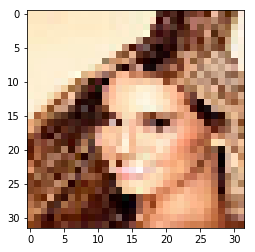

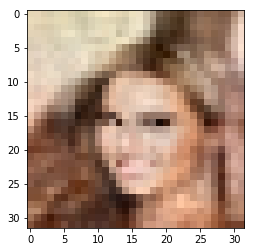

In [12]:
# TODO: fill in this section to accomplish the following.
# 1) display the original image using show_image with height 32 and width 32
# 1) display the projected image using show_image with height 32 and width 32
# BEGIN YOUR CODE
show_image(X[0,:], 32, 32)
show_image(projection, 32, 32)
# END YOUR CODE

### Comment on how well the best Q principal components reconstruct the image:
[TODO: your response here]

In [13]:
def latent_interpolation(z_one, z_two, reconstruction_function, output_height, output_width):
    """This function draws an interpolating animation from one image to another image in the latent space.
    Args:
        z_one: an np.float32 vector with Q elements.
        z_two: an np.float32 vector with Q elements.
        reconstruction_function: a function that takes in z_one or z_two and returns an np.float32 vector with D elements.
        output_height: integer, the height to reshape each image to.
        output_width: integer, the width to reshape each image to.
    """
    fig = plt.figure()
    im = None
    im = plt.imshow(reconstruction_function(z_one).reshape([output_height, output_width, 3]) / 2.0 + 0.5, animated=True)
    def updatefig(t):
        alpha = (0.5 * np.cos(t) + 0.5)
        im.set_array(reconstruction_function(z_one * alpha + z_two * (1.0 - alpha)).reshape([output_height, output_width, 3]) / 2.0 + 0.5)
        return im,
    display(HTML(animation.FuncAnimation(fig, updatefig, frames=np.linspace(0, 2*np.pi, 64), blit=True).to_html5_video()))
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: Requested MovieWriter (ffmpeg) not available

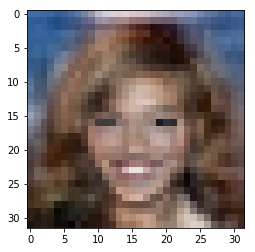

In [14]:
# TODO: fill in this section to accomplish the following.
# 1) select two different rows from the data matrix X
# 2) project each row onto the best Q principal components using V_Q^T
# 3) define reconstruction_function that reconstructs a data point x from its projection onto the best Q principal components using V_Q
# 4) call the function latent_interpolation and generate a visualization with height 32 and width 32 
# BEGIN YOUR CODE
testRow1 = X[1234, :]
testRow2 = X[123, :]

proj1 = projPCA(testRow1)
proj2 = projPCA(testRow2)

def reconstruction_function(projection):
    multiplied_matrices = np.matmul(V_Q, V_Q.transpose())
    reconstructed = np.dot(multiplied_matrices, projection)
    return reconstructed
    
latent_interpolation(proj1, proj2, reconstruction_function, 32, 32)
# END YOUR CODE

### Comment on what happens during the interpolation process:
[TODO: your response here]

In [ ]:
def latent_generation(z_mean, z_stddev, reconstruction_function, output_height, output_width):
    """This function samples from the latent space of the model and shows the resulting image.
    Args:
        z_mean: an np.float32 vector with Q elements.
        z_stddev: an np.float32 matrix with Q by Q elements.
        reconstruction_function: a function that takes in z_one or z_two and returns an np.float32 vector with D elements.
        output_height: integer, the height to reshape each image to.
        output_width: integer, the width to reshape each image to.
    """
    sampled_point = z_mean + z_stddev.dot(np.random.normal(0, 1, z_mean.shape))
    show_image(reconstruction_function(sampled_point), output_height, output_width)

In [ ]:
# TODO: fill in this section to accomplish the following.
# 1) project the data matrix onto best Q principal components using V_Q^T
# 2) compute z_mean as the average of the projected matrix along the 0th axis
# 3) define z_stddev to be the rank Q identity matrix for now
# 4) generate an new image by calling latent_generation with height 32 and width 32 
# BEGIN YOUR CODE

# END YOUR CODE

### Comment on how real the generated face looks:
[TODO: your response here]

## Section Three: Linear Autoencoder

In this section, you will learn about the linear autoencoder, and you will also implement the linear autoencoder using pytorch. We shall use your linear autoencoder to interpolate between data points from $X$ and to also generate new samples of faces.

In [ ]:
class LinearEncoder(torch.nn.Module):
    
    def __init__(self, image_height, image_width, hidden_size):
        """Creates a single layer neural network.
        Args:
            image_height: an integer, the height of each image
            image_width: an integer, the width of each image
            hidden_size: an integer, the number of neurons in the hidden layer of this network
        """
        super(LinearEncoder, self).__init__()
        # TODO: fill in this section to accomplish the following.
        # 1) create a single layer neural network that performs a linear transformation from a vector with 
        #    image_height * image_width * 3 dimensions to a vector with hidden_size dimensions.
        #    HINT: consider the class torch.nn.Linear
        # BEGIN YOUR CODE
        # END YOUR CODE
        
    def forward(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, D]
        Returns:
            a float32 tensor with shape [batch_size, hidden_size]
        """
        # TODO: fill in this section to accomplish the following.
        # 1) perform a forward pass using the hidden layer you defined
        # 2) return the resulting vector
        # BEGIN YOUR CODE
        # END YOUR CODE

In [ ]:
class LinearDecoder(torch.nn.Module):
    
    def __init__(self, image_height, image_width, hidden_size):
        """Creates a single layer neural network.
        Args:
            image_height: an integer, the height of each image
            image_width: an integer, the width of each image
            hidden_size: an integer, the number of neurons in the hidden layer of this network
        """
        super(LinearDecoder, self).__init__()
        # TODO: fill in this section to accomplish the following.
        # 1) create a single layer neural network that performs a linear transformation from a vector with 
        #    hidden_size dimensions to a vector with image_height * image_width * 3 dimensions.
        #    HINT: consider the class torch.nn.Linear
        # BEGIN YOUR CODE
        # END YOUR CODE
        
    def forward(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, hidden_size]
        Returns:
            a float32 tensor with shape [batch_size, D]
        """
        # TODO: fill in this section to accomplish the following.
        # 1) perform a forward pass using the hidden layer you defined
        # 2) return the resulting vector
        # BEGIN YOUR CODE
        # END YOUR CODE

In [ ]:
linear_encoder = None
linear_decoder = None
linear_autoencoder_loss = None
linear_autoencoder_optimizer = None
# TODO: fill in this section to accomplish the following.
# 1) create an instance of LinearEncoder named linear_encoder with height 32, width 32, and hidden size Q
# 1) create an instance of LinearDecoder named linear_decoder with height 32, width 32, and hidden size Q
# 2) assign linear_autoencoder_loss to be an instance of torch.nn.MSELoss
# 2) create an optimizer named linear_autoencoder_optimizer of your choosing with a learning rate of your choosing.
#    HINT: consider the torch.optim.Adam object
# BEGIN YOUR CODE
# END YOUR CODE

In [ ]:
# TODO: run the following section of code in order to train the model
# Construct a tensor from the dataset
image_tensor = torch.FloatTensor(X)
for i in range(1000):
    # Clear the previous gradient from the optimizer by calling .zero_grad()
    linear_autoencoder_optimizer.zero_grad()
    # Compute a full encoding and decoding step
    reconstructed_image = linear_decoder(linear_encoder(image_tensor))
    # Compute the mean squared reconstruction loss
    loss = linear_autoencoder_loss(reconstructed_image, image_tensor)
    # Pass the loss backward throgh the network, and compute the gradients
    loss.backward()
    # Update the optimizer by calling .step()
    linear_autoencoder_optimizer.step()
    # Return a detatched value of the loss for logging purposes
    print("On iteration {0} the loss was {1}.".format(i, loss.detach()))

In [ ]:
# TODO: run the following section of code to define the reconstruction function
def linear_autoencoder_reconstruction_function(z):
    return linear_decoder(torch.FloatTensor(z[np.newaxis, :])).detach()[0, :]

In [ ]:
# TODO: fill in this section to accomplish the following.
# 1) select two different rows from the data matrix X
# 2) compute the hidden representation for each row using your linear_encoder
# 3) call the function latent_interpolation and generate a visualization with height 32 and width 32 
# BEGIN YOUR CODE
# END YOUR CODE

### Comment on what happens during the interpolation process:
[TODO: your response here]

In [ ]:
# TODO: fill in this section to accomplish the following.
# 1) compute the hidden representation of each row of the data matrix
# 2) compute z_mean as the average of the hidden representation matrix along the 0th axis
# 3) define z_stddev to be the rank Q identity matrix for now
# 4) generate an new image by calling latent_generation with height 32 and width 32 
# BEGIN YOUR CODE
# END YOUR CODE

### Comment on how real the generated face looks:
[TODO: your response here]

### Comment on how the linear autoencoder compares to PCA:
[TODO: your response here]

## Section Four: Convolutional Autoencoder

In this section, you will learn about the convolutional autoencoder, and you will also implement the convolutional autoencoder using pytorch. We shall use your convolutional autoencoder to interpolate between data points from $X$ and to also generate new samples of faces.

In [16]:
class ConvolutionalEncoder(torch.nn.Module):
    
    def __init__(self, image_height, image_width, final_size):
        """Creates a deep convolutional neural network.
        Args:
            image_height: an integer, the height of each image
            image_width: an integer, the width of each image
            final_size: an integer, the depth of the final layer of this network
        """
        super(ConvolutionalEncoder, self).__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.final_size = max(16 * 3, final_size)
        # TODO: fill in this section to accomplish the following.
        # 1) create a 5 layer convolutional neural network that transforms an image with shape
        #    [image_height, image_width, 3] to a vector with final_size dimensions.
        #    HINT: consider the class torch.nn.Conv2d with stride=2
        # BEGIN YOUR CODE
        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=2,
            stride=2
        )

        self.conv2 = torch.nn.Conv2d(
            in_channels=8,
            out_channels=64,
            kernel_size=2,
            stride=2
        )

        
        self.conv3 = torch.nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=2,
            stride=2
        )

        self.conv4 = torch.nn.Conv2d(
            in_channels=128,
            out_channels=164,
            kernel_size=2,
            stride=2,
        )

        self.conv5 = torch.nn.Conv2d(
            in_channels=164,
            out_channels=256,
            kernel_size=2,
            stride=2
        )

        
        #self.output_shape = (int(self.image_height/2/2), int(self.image_width/2/2), 1)
        #self.fc1 = torch.nn.Linear(np.prod(self.output_shape), 128)
        #self.output_fc = torch.nn.Linear(128, self.final_size)
        
        # END YOUR CODE
        
    def forward(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, D]
        Returns:
            a float32 tensor with shape [batch_size, final_size]
        """
        x = x.view(x.size()[0], self.image_height, self.image_width, 3)
        x = torch.transpose(x, 1, 3)
        # TODO: fill in this section to accomplish the following.
        # 1) perform a forward pass using the conv layers you defined
        # 2) apply any activation function you want
        # BEGIN YOUR CODE
        #print(x.size())
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = F.relu(self.conv2(x))
        #print(x.size())
        x = F.relu(self.conv3(x))
        #print(x.size())
        x = F.relu(self.conv4(x))
        #print(x.size())
        x = F.relu(self.conv5(x))
        #print(x.size())
        
        #x = F.relu(self.fc1(x))
        #x = self.output_fc(x)
        # END YOUR CODE
        x = torch.transpose(x, 1, 3)
        x = x.contiguous()
        #encoder
        x = x.view(x.size()[0], self.final_size)
        return x

In [17]:
class ConvolutionalDecoder(torch.nn.Module):
    
    def __init__(self, image_height, image_width, final_size):
        """Creates a deep convolutional neural network.
        Args:
            image_height: an integer, the height of each image
            image_width: an integer, the width of each image
            final_size: an integer, the depth of the final layer of this network
        """
        super(ConvolutionalDecoder, self).__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.final_size = max(16 * 3, final_size)
        # TODO: fill in this section to accomplish the following.
        # 1) create a 5 layer transpose convolutional neural network that transforms a vector with 
        #    final_size dimensions to an image with shape [image_height, image_width, 3]
        #    HINT: consider the class torch.nn.ConvTranspose2d with stride=2
        # BEGIN YOUR CODE
        self.conv1 = torch.nn.ConvTranspose2d(
            in_channels=256,
            out_channels=164,
            kernel_size=2,
            stride=2
        )
        
        self.conv2 = torch.nn.ConvTranspose2d(
            in_channels=164,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        
        self.conv3 = torch.nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        
        
        self.conv4 = torch.nn.ConvTranspose2d(
            in_channels=64,
            out_channels=8,
            kernel_size=2,
            stride=2
        )
        
        self.conv5 = torch.nn.ConvTranspose2d(
            in_channels=8,
            out_channels=3,
            kernel_size=2,
            stride=2
        )
    
        # END YOUR CODE
        
    def forward(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, final_size]
        Returns:
            a float32 tensor with shape [batch_size, D]
        """
        x = x.view(x.size()[0], 1, 1, self.final_size)
        x = torch.transpose(x, 1, 3)
        # TODO: fill in this section to accomplish the following.
        # 1) perform a forward pass using the conv layers you defined
        # 2) apply any activation function you want
        # BEGIN YOUR CODE
        #print("decoder start")
        #print(x.size())
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = F.relu(self.conv2(x))
        #print(x.size())
        x = F.relu(self.conv3(x))
        #print(x.size())
        x = F.relu(self.conv4(x))
        #print(x.size())
        x = F.relu(self.conv5(x))
        #print(x.size())
        
        # END YOUR CODE
        x = torch.transpose(x, 1, 3)
        x = x.contiguous()
        x = x.view(x.size()[0], self.image_height * self.image_width * 3)
        return x

In [18]:
convolutional_encoder = None
convolutional_decoder = None
convolutional_autoencoder_loss = None
convolutional_autoencoder_optimizer = None
# TODO: fill in this section to accomplish the following.
# 1) create an instance of ConvolutionalEncoder named convolutional_encoder with height 32, width 32, and hidden size Q
# 1) create an instance of ConvolutionalDecoder named convolutional_decoder with height 32, width 32, and hidden size Q
# 2) assign convolutional_autoencoder_loss to be an instance of torch.nn.MSELoss
# 2) create an optimizer named convolutional_autoencoder_optimizer of your choosing with a learning rate of your choosing.
#    HINT: consider the torch.optim.Adam object
# BEGIN YOUR CODE
convolutional_encoder = ConvolutionalEncoder(32, 32, Q)
convolutional_decoder = ConvolutionalDecoder(32, 32, Q)
convolutional_autoencoder_loss = torch.nn.MSELoss()
convolutional_autoencoder_optimizer = torch.optim.Adam(convolutional_encoder.parameters(), lr=0.1)
# END YOUR CODE

In [19]:
X

array([[ 0.99212599,  0.81889766,  0.52755904, ..., -0.13385826,
        -0.65354329, -0.85826772],
       [-0.48818898, -0.60629922, -0.66141731, ...,  0.02362205,
        -0.20472442, -0.23622048],
       [ 1.00787401,  1.00787401,  1.00787401, ..., -0.26771653,
        -0.28346458, -0.25984251],
       ...,
       [ 0.38582677,  0.50393701,  0.48031497, ..., -0.55905509,
        -0.82677168, -0.83464569],
       [-0.48031497, -0.66929132, -0.70078743, ...,  0.02362205,
         0.11811024, -0.24409449],
       [ 0.85826772,  0.89763778,  0.92913383, ..., -0.72440946,
        -0.73228347, -0.7480315 ]])

In [20]:
# TODO: run the following section of code in order to train the model
# Construct a tensor from the dataset
image_tensor = torch.FloatTensor(X)
for i in range(1000):
    # Clear the previous gradient from the optimizer by calling .zero_grad()
    convolutional_autoencoder_optimizer.zero_grad()
    # Compute a full encoding and decoding step
    reconstructed_image = convolutional_decoder(convolutional_encoder(image_tensor))
    # Compute the mean squared reconstruction loss
    loss = convolutional_autoencoder_loss(reconstructed_image, image_tensor)
    # Pass the loss backward throgh the network, and compute the gradients
    loss.backward()
    # Update the optimizer by calling .step()
    convolutional_autoencoder_optimizer.step()
    # Return a detatched value of the loss for logging purposes
    print("On iteration {0} the loss was {1}.".format(i, loss.detach()))

KeyboardInterrupt: 

In [ ]:
# TODO: run the following section of code to define the reconstruction function
def convolutional_autoencoder_reconstruction_function(z):
    return np.asarray(convolutional_decoder(torch.FloatTensor(z[np.newaxis, :])).detach()[0, :], np.float32)

In [21]:
# TODO: fill in this section to accomplish the following.
# 1) select two different rows from the data matrix X
# 2) compute the hidden representation for each row using your convolutional_encoder
# 3) call the function latent_interpolation and generate a visualization with height 32 and width 32 
# BEGIN YOUR CODE
image = torch.FloatTensor(X)
row1 = convolutional_encoder(image)[0]
row2 = convolutional_encoder(image)[1]

latent_interpolation(projPCA(row1), projPCA(row2), convolutional_autoencoder_reconstruction_function, 32, 32)
# END YOUR CODE

TypeError: Cannot find a common data type.

### Comment on what happens during the interpolation process:
[TODO: your response here]

In [ ]:
# TODO: fill in this section to accomplish the following.
# 1) compute the hidden representation of each row of the data matrix using convolutional_encoder
# 2) compute z_mean as the average of the hidden representation matrix along the 0th axis
# 3) define z_stddev to be the rank Q identity matrix for now
# 4) generate an new image by calling latent_generation with height 32 and width 32 
# BEGIN YOUR CODE
# END YOUR CODE

### Comment on how real the generated face looks:
[TODO: your response here]

### Comment on how the convolutional autoencoder compares to the linear autoencoder and PCA:
[TODO: your response here]

## (Optional) Section Five: Variational Autoencoder

In this section, we implement the Variational Autoencoder, an extension for the traditional autoencoder that explicitly models the probability distribution of a latent variable. This section is optional, and so we fill in the code for you. If you have extra time after completing the rest of this homework, you should first read this tutorial on variational inference https://arxiv.org/pdf/1606.05908.pdf. Then, you may attempt to train the VAE given below.

In [ ]:
# TODO: run the following section of code
class Sampler(torch.nn.Module):
    
    def __init__(self, hidden_size):
        """Creates a Variational sampling layer.
        Args:
            hidden_size: an integer, the number of neurons in the sampling layer.
        """
        super(Sampler, self).__init__()
        self.hidden_size = hidden_size
        self.log_scale = torch.nn.Linear(hidden_size, hidden_size)
        self.shift = torch.nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, hidden_size]
        Returns:
            a float32 tensor with shape [batch_size, hidden_size]
        """
        scale = torch.exp(self.log_scale(x))
        shift = self.shift(x)
        sample = torch.randn([self.hidden_size]) * scale + shift
        return sample
        
    def kl_penalty(self, x):
        """Computes a single forward pass of this network.
        Args:
            x: a float32 tensor with shape [batch_size, hidden_size]
        Returns:
            a float32 scalar: KL divergence between this distribution and the standard normal distribution.
        """
        log_scale = self.log_scale(x)
        scale = torch.exp(log_scale)
        shift = self.shift(x)
        return torch.mean(log_scale + (1.0 + shift * shift) / (2.0 * scale * scale) - 0.5)

In [ ]:
# TODO: run the following section of code
variational_encoder = ConvolutionalEncoder(32, 32, 256)
variational_decoder = ConvolutionalDecoder(32, 32, 256)
sampler = Sampler(256)
variational_autoencoder_loss = torch.nn.MSELoss()
variational_autoencoder_optimizer = torch.optim.Adam([
    {"params": variational_encoder.parameters()}, 
    {"params": variational_decoder.parameters()}, 
    {"params": sampler.parameters()}])

In [ ]:
# TODO: run the following section of code in order to train the model
# Construct a tensor from the dataset
image_tensor = torch.FloatTensor(X)
for i in range(10000):
    # Clear the previous gradient from the optimizer by calling .zero_grad()
    variational_autoencoder_optimizer.zero_grad()
    # Compute a full encoding and decoding step
    hidden_variables = variational_encoder(image_tensor)
    reconstructed_image = variational_decoder(sampler(hidden_variables))
    # Compute the mean squared reconstruction loss
    loss = variational_autoencoder_loss(reconstructed_image, image_tensor) - sampler.kl_penalty(hidden_variables)
    # Pass the loss backward throgh the network, and compute the gradients
    loss.backward()
    # Update the optimizer by calling .step()
    variational_autoencoder_optimizer.step()
    # Return a detatched value of the loss for logging purposes
    print("On iteration {0} the loss was {1}.".format(i, loss.detach()))

In [ ]:
# TODO: run the following section of code
def variational_autoencoder_reconstruction_function(z):
    return np.asarray(variational_decoder(torch.FloatTensor(z[np.newaxis, :])).detach()[0, :], np.float32)

In [ ]:
# TODO: run the following section of code
x_one = X[0, :]
x_two = X[1, :]
z_one = np.asarray(sampler(variational_encoder(torch.FloatTensor(x_one[np.newaxis, :]))).detach(), np.float32)
z_two = np.asarray(sampler(variational_encoder(torch.FloatTensor(x_two[np.newaxis, :]))).detach(), np.float32)
latent_interpolation(z_one, z_two, convolutional_autoencoder_reconstruction_function, 32, 32)

### Comment on what happens during the interpolation process:
[TODO: your response here]

In [ ]:
# TODO: run the following section of code
z_mean = np.asarray(torch.mean(sampler(variational_encoder(torch.FloatTensor(X))), 0).detach(), np.float32)
z_stddev = np.identity(Q)
latent_generation(z_mean, z_stddev, convolutional_autoencoder_reconstruction_function, 32, 32)

### Comment on how real the generated face looks:
[TODO: your response here]

### Comment on how the convolutional autoencoder compares to the linear autoencoder and PCA:
[TODO: your response here]